# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

Built by Dmitry Zaganich in August 2017.

---
## Dependencies and settings

In [1]:
import pickle
import os
import zipfile
import sys
import random
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import datetime
import time
%matplotlib inline

import numpy as np
import tensorflow as tf

from imgaug import augmenters as iaa
import imgaug as ia
from skimage import exposure
import warnings

import json

from sklearn.utils import shuffle
from urllib.request import urlretrieve

In [2]:
# version properties

# turn on/off generating additional data
skip_generation = False

# turn on/off training stage
# the model will be loaded from model/ directory
skip_training = False

# model version and model name
classifier_name = "Inception_Conv_Fc"
classifier_version = "2.1.0"

model_name = classifier_version+"_"+classifier_name

In [3]:
# print live progress of an operation

def print_operation_progress(progress):
    if progress<100:
        sys.stdout.write("Operation in progress: %3.1f%%   \r" % (progress) )
    else:
        sys.stdout.write("                                               \r")
    sys.stdout.flush()

In [4]:
# show plots in big resolution

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

---
## Dataset loading

In [5]:
# download German Traffic Sign Dataset

def print_download_progress(count, blockSize, totalSize):
    progress = int(count * blockSize * 100 / totalSize)
    print_operation_progress(progress)

def load_and_extract_dataset(data_folder, url):
    train_name = data_folder+'train.p'
    valid_name = data_folder+'valid.p'
    test_name = data_folder+'test.p'
    
    if os.path.isfile(train_name) and os.path.isfile(valid_name) and os.path.isfile(test_name):
        print("Dataset is ready")
        return train_name, valid_name, test_name
    
    archive_name = data_folder+"data.zip"
   
    if not os.path.isfile(archive_name):
        print('Loading dataset archive...')
        urlretrieve(url, archive_name, reporthook=print_download_progress)
        print_operation_progress(100)
        print('Dataset archive was loaded')

    print('Opening dataset archive...')
    with zipfile.ZipFile(archive_name,"r") as archive:
        archive.extractall(data_folder)
            
    print('Clean up the archive file...')
    
    os.remove(archive_name)
    
    print("Dataset is ready")
    
    return train_name, valid_name, test_name

data_folder = "data/"

# the link is provided by CarND
data_link = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
    
training_file, validation_file, testing_file = load_and_extract_dataset(data_folder, data_link)

Dataset is ready


In [6]:
# Load data

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

### Dataset summary

In [7]:
# basic info about dataset

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Number of the unique classes/labels in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

print("Shape of training set =", X_train.shape)
print("Shape of validation set =", X_valid.shape)
print("Shape of test set =", X_test.shape)


print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Shape of training set = (34799, 32, 32, 3)
Shape of validation set = (4410, 32, 32, 3)
Shape of test set = (12630, 32, 32, 3)
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of classes in the dataset

ClassId, SignName
0, Speed limit (20km/h)
1, Speed limit (30km/h)
2, Speed limit (50km/h)
3, Speed limit (60km/h)
4, Speed limit (70km/h)
5, Speed limit (80km/h)
6, End of speed limit (80km/h)
7, Speed limit (100km/h)
8, Speed limit (120km/h)
9, No passing
10, No passing for vehicles over 3.5 metric tons
11, Right-of-way at the next intersection
12, Priority road
13, Yield
14, Stop
15, No vehicles
16, Vehicles over 3.5 metric tons prohibited
17, No entry
18, General caution
19, Dangerous curve to the left
20, Dangerous curve to the right
21, Double curve
22, Bumpy road
23, Slippery road
24, Road narrows on the right
25, Road work
26, Traffic signals
27, Pedestrians
28, Children crossing
29, Bicycles crossing
30, Beware of ice/snow
31, Wild animals crossing
32, End of all speed and passing limits
33, Turn right ahead
34, Turn left ahead
35, Ahead only
36, Go straight or right
37, Go straight or left
38, Keep right
39, Keep left
40, Roundabout mandatory
41, End of no passing
42, End of n

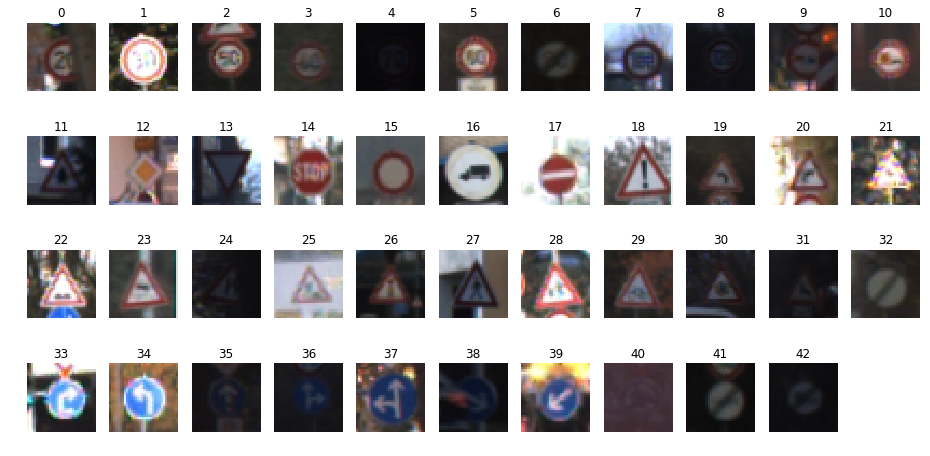

In [8]:
# show all of the signs in dataset and their descriptions

# print descriptions
labels_text = []
i = 0
with open('signnames.csv', 'r') as desc_file:
    reader = csv.reader(desc_file, delimiter=',')
    for row in reader:
        print(', '.join(row))
        if i > 0:
            labels_text.append(row[1])        
        i = i + 1
        
# Show examples of each class in dataset
_, i_samples = np.unique(y_valid, return_index=True)
X_samples = X_valid[i_samples, :, :, :]
for i in range(0, len(i_samples)):
    plt.subplot(4, 11, i+1);
    plt.imshow(X_samples[i, :, :, :]);
    plt.title(i);
    plt.axis('off');

###  Distributions of classes in the dataset

In [9]:
# function for retrieving a disribution of classes from dataset 

def get_distribution(X, n_classes):
    classes = np.array(range(0, n_classes))
    samples = np.zeros(n_classes, dtype=np.int32)
    for i in classes:
        samples[i] = sum(X == i)
        
    return (classes, samples)

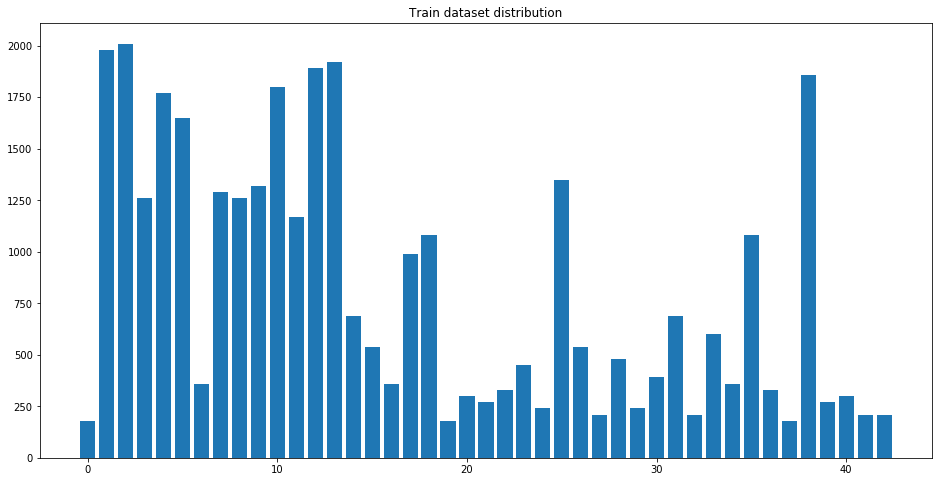

In [10]:
# show plot with distribution of train dataset
classes, samples_train = get_distribution(y_train, n_classes)
plt.bar(classes, samples_train);
plt.title("Train dataset distribution");

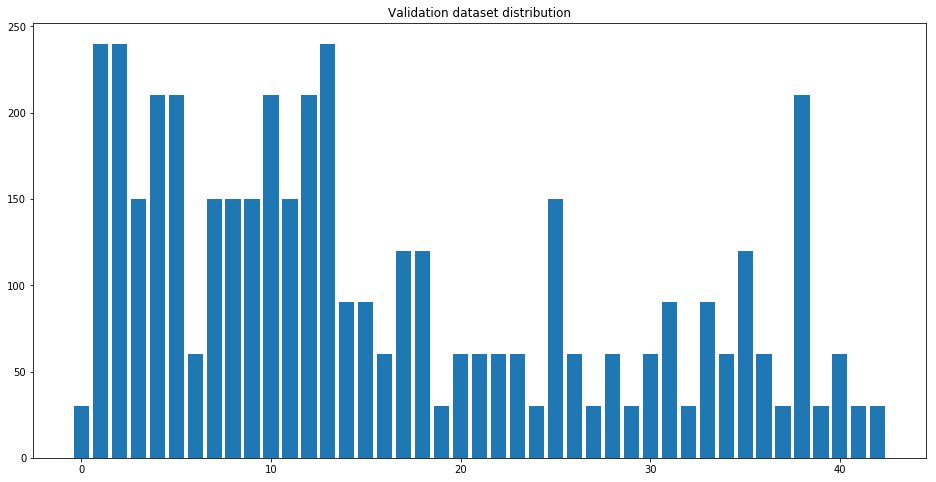

In [11]:
# show plot with distribution of validation dataset
classes, samples_valid = get_distribution(y_valid, n_classes)
plt.bar(classes, samples_valid);
plt.title("Validation dataset distribution");

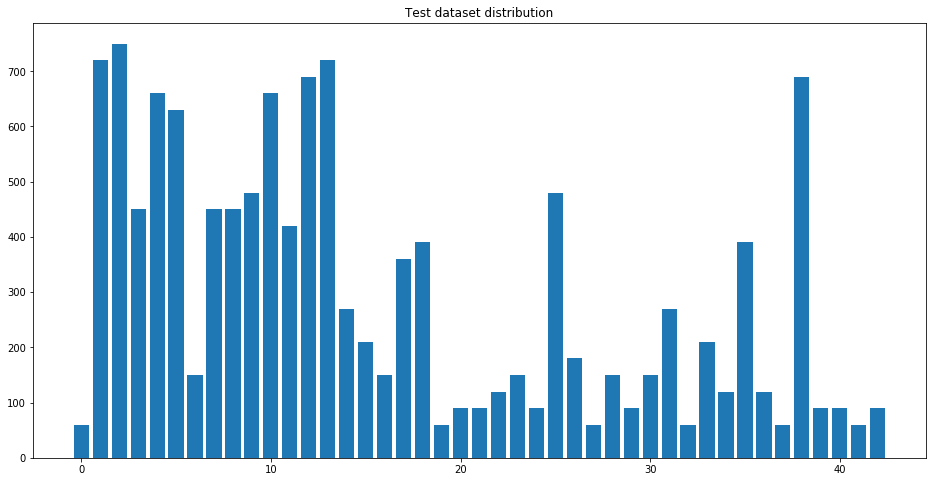

In [12]:
# show plot with distribution of test dataset
classes, samples_test = get_distribution(y_test, n_classes)
plt.bar(classes, samples_test);
plt.title("Test dataset distribution");

### Exploration summary

The dataset does not contain images with specific standard of image brightness and contrast, so it does not seem to be a good idea to train classifier on raw images. We should normalize all the images, so network may generalize well. 

The classes of signs are not equally distributed, so network may not generalise well for the classes which have a small amount of examples. In order to make network more robust dataset should become more balanced which leads us to the problem of generation additional data.

----

## Design a model architecture


I highly relied on Pierre Sermanet and Yann LeCun's paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" in the process of designing my network. I also found Tommy Mulc's explanation of Inception modules very helpful and I used preprocessing technique described in Alex Staravoitau's blog. 

- Pierre Sermanet and Yann LeCun's paper: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
- Tommy Mulc's blog: https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/
- Alex Staravoitau's blog: https://navoshta.com/traffic-signs-classification/

I also used links from https://github.com/frankkanis/CarND-Student-Blogs to get an insight on how other students approached the problem. In the end, I've designed a model which performs classification by using the following techniques:

- `'Data augmentation'`. Using the same techniques as described in LeCun's paper I extend my dataset so it becomes 2 times larger and the distribution of classes becomes more balanced.
- `'Data preprocessing'`. Using the approach from Alex Staravoitau's blog I normalize my dataset, convert it to grayscale and perform histogram equalization on each image.
- `'Training convolutional neural network'`. My classifier contains one inception module, like the ones in Google LeNet, one convolutional layer, one fully connected layer and an output layer.  

----

## Dataset augmentation

### Generate new data and equalize distributions

I used a set of different generation techniques, which included translation, rotation, scaling, adding noise to image and blurring. Adding noise and blurring does not seem to improve performance of my network, so in the end I used translation, rotation and scaling as described in LeCun's paper with the same parametres.

In [44]:
# functions to generate new images

def apply_affine_transform(img, T):
    rows, cols, ch = img.shape
    return cv2.warpAffine(img, T, (cols, rows))

def random_translate(img, max_displacement = 2):
    h, w =  img.shape[0:2]
    
    tx = np.random.uniform(-max_displacement, max_displacement)
    ty = np.random.uniform(-max_displacement, max_displacement)
    
    T = np.array([[1.0, 0.0, tx], [0.0, 1.0, ty]], dtype = np.float32)

    return apply_affine_transform(img, T)

def random_rotate(img, max_angle_degrees = 15.0):
    theta = np.random.uniform(-max_angle_degrees, max_angle_degrees) * np.pi/180.0
    
    c = np.cos(theta)
    s = np.sin(theta)
    
    T = np.array([[c, -s, 0.0], [s, c, 0.0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def random_scale(img, max_scale_factor = 0.1):    
    sx = 1.0 + np.random.uniform(-max_scale_factor, max_scale_factor)
    sy = 1.0 + np.random.uniform(-max_scale_factor, max_scale_factor)
    
    T = np.array([[sx, 0.0, 0.0], [0.0, sy, 0.0]], dtype = np.float32)
    return apply_affine_transform(img, T)

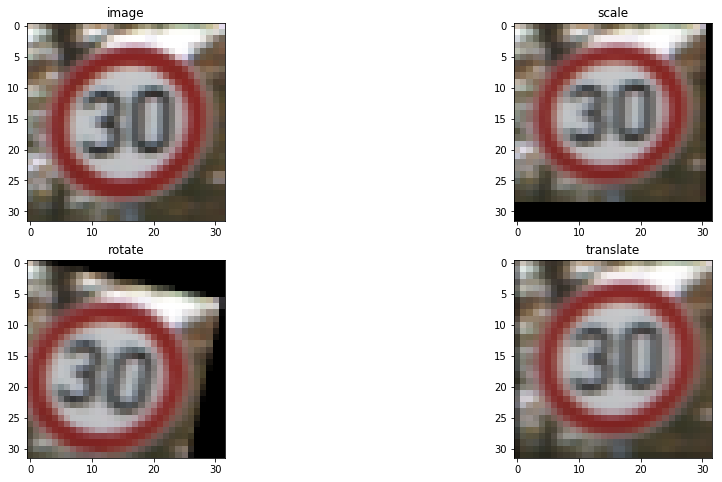

In [43]:
# show random example of every transformation

random_num = random.randint(0, len(X_train))
random_image = X_train[random_num].squeeze()

plt.subplot(2,2,1)
plt.imshow(random_image, cmap='gray');
plt.title("image")
plt.subplot(2,2,2)
plt.imshow(random_scale(random_image), cmap='gray');
plt.title("scale")
plt.subplot(2,2,3)
plt.imshow(random_rotate(random_image), cmap='gray');
plt.title("rotate")
plt.subplot(2,2,4)
plt.imshow(random_translate(random_image), cmap='gray');
plt.title("translate")

In [15]:
def generate_extended_dataset(X, y, transform_functions, times = 2):
    n_classes = len(set(y))
    
    classes, samples_old = get_distribution(y, n_classes)
    
    extended_size = X.shape[0] * times
    
    images_per_class = int(np.ceil(extended_size / n_classes))
    
    X_transformed = []
    y_transformed = []
    
    for i in range(X.shape[0]):
        samples_old_per_class = samples_old[y[i]]
        
        samples_to_generate_per_class = int(np.ceil((images_per_class - samples_old_per_class) / samples_old_per_class))        
        
        progress = i/float(X.shape[0])
        print_operation_progress(progress*100)
        
        for j in range(samples_to_generate_per_class):
            random_transform = np.random.randint(0, len(transform_functions))
            X_transformed.append(transform_functions[random_transform](X[i]))
            y_transformed.append(y[i])
            
    X_generated = np.concatenate((X, X_transformed), axis = 0)
    y_generated = np.concatenate((y, y_transformed), axis = 0)
    
    print_operation_progress(100.0)
    
    return X_generated, y_generated

In [16]:
# Extend dataset

if skip_generation:
    X_generated_train = X_train
    y_generated_train = y_train
    print("Dataset generation was skipped")
else:
    # define set of transform functions to use
    transform_functions = [random_translate, random_rotate, random_scale]

    gen_factor = 2

    X_generated_train, y_generated_train = generate_extended_dataset(X_train, y_train, 
                                                                     transform_functions, 
                                                                     gen_factor)

    print("Dataset generation completed")

Dataset generation completed                   


Training examples after generation = :  81807


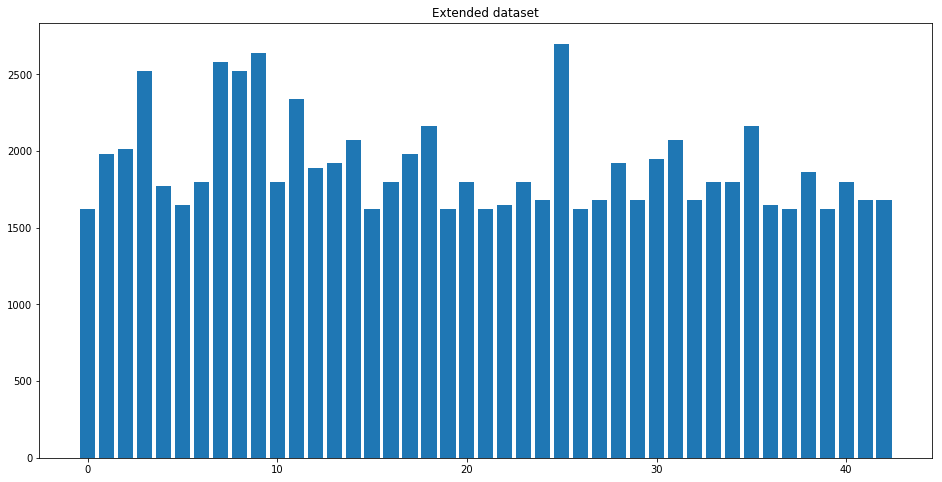

In [17]:
# show the distribution of the generated data

print("Training examples after generation = : ", len(X_generated_train))

classes, samples = get_distribution(y_generated_train, n_classes)
plt.bar(classes, samples);
plt.title("Extended dataset");

### Preprocess dataset

I tried to train network on color and grayscale images and, as it was mentioned in LeCun's paper, the model performs better on grayscale images. I also found approach with histogram equalization very helpful as it increased accuracy on the test set from 93% to 96%. 

In [18]:
def preprocess_set(X):
    # Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
        
    # Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
      
    # Apply localized histogram localization  
    for i in range(X.shape[0]):
        
        progress = i/float(X.shape[0])
        print_operation_progress(progress*100)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    
    print_operation_progress(100.0)
    
    return X


def one_hot_encoding(y_data, depth):
    return np.eye(depth)[y_data]

In [19]:
print("Preprocessing train set...")
X_train_preprocessed = preprocess_set(X_generated_train)
y_train_preprocessed = one_hot_encoding(y_generated_train, n_classes)

print("Preprocessing validation set...")
X_valid_preprocessed = preprocess_set(X_valid)
y_valid_preprocessed = one_hot_encoding(y_valid, n_classes)

print("Preprocessing test set...")
X_test_preprocessed = preprocess_set(X_test)
y_test_preprocessed = one_hot_encoding(y_test, n_classes)

print("Preprocessing complete")

Preprocessing train set...
Preprocessing validation set...                
Preprocessing test set...                      
Preprocessing complete                         


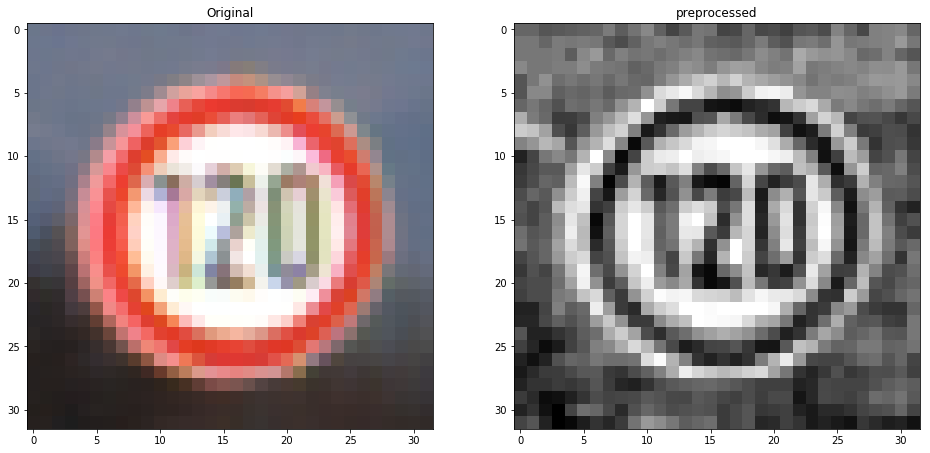

In [20]:
# show random example of image preprocessing

random_num = random.randint(0, len(X_train))

random_image = X_generated_train[random_num].squeeze()
random_image_preprocessed = X_train_preprocessed[random_num].squeeze()

plt.subplot(1,2,1)
plt.imshow(random_image, cmap='gray');
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(random_image_preprocessed, cmap='gray');
plt.title("preprocessed")

### Assign final dataset variables

In [21]:
# assign final variables before moving to the next step

X_train_final = X_train_preprocessed
y_train_final = y_train_preprocessed

X_valid_final = X_valid_preprocessed
y_valid_final = y_valid_preprocessed

X_test_final = X_test_preprocessed
y_test_final = y_test_preprocessed

----

## Model Architecture

In the process of implementation of this project I used 3 different architectures: 
- LeNet, which was provided in CarND "Convolutional networks" section. I've got accuracy on test set around 89%.
- A network with 3 convolutional layers and 2 fully connected layers. This network provided accuracy of 93% on the test set.
- The final version of my classifier which uses one "Inception module", one convolutional layer and one fully connected layer. This solution provided accuracy of 96,3% on the test set.

My decision of final network architecture was influenced by my desire to understand Inception modules and trying to implement a network, similar to Google LeNet. Unfortunately, I could not train such a deep network on my GPU, so I used smaller model insted.

I used learning rate 0.0001, which is smaller than it was in the lab, because smaller rate provided me an accuracy boost. 

In [22]:
# utils

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))    
    
def create_biases(shape):    
    return tf.Variable(tf.zeros(shape) + 0.05)

def flatten_layer(layer):
    # Shape is [batch_size, img_h, img_w, img_depth]    
    layer_shape = layer.get_shape()
    
    # Number of features per image
    num_features = layer_shape[1:4].num_elements()
    
    # Must reshape into [batch_size, n_features]. Since the batch_size is unknown
    # we type -1 so tf will figure it out itself
    return tf.reshape(layer, [-1, num_features])

In [23]:
# layer builders

def apply_max_pooling(x, size=2):
        return tf.nn.max_pool(x,ksize=[1,size,size,1],
                             strides=[1,1,1,1],padding='SAME')

def create_conv_layer(input_layer,                
                      filter_size,               
                      n_filters,            
                      use_pooling=False,        
                      use_relu=False,             
                      dropout_keep_prob=None    
                     ):    

    # Create weights (4D tensor) and biases (1D vector)
    input_depth = int(input_layer.get_shape()[3])
    weight_shape = [filter_size, filter_size, input_depth, n_filters]
    bias_shape = [n_filters]
    
    weights = create_weights(weight_shape)
    biases = create_biases(bias_shape)
    
    # Convolution
    layer = tf.nn.conv2d(input=input_layer, 
                         filter=weights,
                         strides=[1,1,1,1], 
                         padding='SAME')
    
    # Add bias
    layer = tf.nn.bias_add(layer, biases)
    
    # Max pooling
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1,2,2,1],
                               strides=[1,2,2,1],
                               padding='SAME')
    
    # ReLU Actiontion
    if use_relu:
        layer = tf.nn.relu(layer)
    
    # Dropout
    if dropout_keep_prob is not None:
        layer = tf.nn.dropout(layer, dropout_keep_prob)
    
    return layer

def create_fc_layer(input_layer,               
                    n_outputs,                 
                    use_relu=True,             
                    dropout_keep_prob=None     
                   ):        

    n_inputs = int(input_layer.get_shape()[1])
    weights = create_weights([n_inputs, n_outputs])
    biases = create_biases([n_outputs])
    
    # XW + b
    layer = tf.matmul(input_layer, weights)
    layer = tf.nn.bias_add(layer, biases)
    
    # ReLU
    if use_relu:
        layer = tf.nn.relu(layer)
    
    # Dropout
    if dropout_keep_prob is not None:
        layer = tf.nn.dropout(layer, dropout_keep_prob)
    
    return layer   

def create_inception_layer(input_layer, 
                           inception_n_conv_filters, 
                           inception_n_reduce_filters):        

    conv1_1x1_1 = create_conv_layer(input_layer=x, filter_size=1, n_filters=inception_n_conv_filters, 
                                use_pooling=False, use_relu=False)

    conv1_1x1_2 = create_conv_layer(input_layer=x, filter_size=1, n_filters=inception_n_reduce_filters, 
                                    use_pooling=False, use_relu=True)

    conv1_1x1_3 = create_conv_layer(input_layer=x, filter_size=1, n_filters=inception_n_reduce_filters, 
                                    use_pooling=False, use_relu=True)

    conv1_3x3 = create_conv_layer(input_layer=conv1_1x1_2, filter_size=3, n_filters=inception_n_conv_filters)

    conv1_5x5 = create_conv_layer(input_layer=conv1_1x1_3, filter_size=5, n_filters=inception_n_conv_filters)

    maxpool1 = apply_max_pooling(x, size=3)

    conv1_1x1_4 = create_conv_layer(input_layer=maxpool1, filter_size=1, n_filters=inception_n_conv_filters)

    inception = tf.nn.relu(tf.concat([conv1_1x1_1, conv1_3x3, conv1_5x5, conv1_1x1_4], 3))
    
    print("conv1_1x1_1 = ", conv1_1x1_1)
    print("conv1_1x1_2 = ", conv1_1x1_2)
    print("conv1_1x1_3 = ", conv1_1x1_3)
    print("conv1_3x3 = ", conv1_3x3)
    print("conv1_5x5 = ", conv1_5x5)
    print("maxpool1 = ", maxpool1)
    print("conv1_1x1_4 = ", conv1_1x1_4)
    print("inception = ", inception)
    
    return inception   

In [24]:
# Network parameters

# Input
img_size_w = X_train_final.shape[1]
img_size_h = X_train_final.shape[2]
img_size_d = X_train_final.shape[3]

# Placeholder variables

# Input: batch of images - 4D tensor [batch_size, img_h, img_w, img_d]
x = tf.placeholder(tf.float32, shape=[None, img_size_h, img_size_w, img_size_d])

# Output: true class - 2D matrix, one-hot encoded value [batch_size, n_classes]
y_true = tf.placeholder(tf.float32, shape=[None, n_classes])

# True class (not hot encoded) vector [batch_size]
y_true_class = tf.argmax(y_true, dimension=1)

# Dropout keep probability
dropout_keep_p = tf.placeholder(tf.float32)

inc1_n_conv_filters = 16
inc1_n_reduce_filters = 8

conv2_filter_size = 5
conv2_n_filters = 128

# Fully Connected 1
fc1_n_neurons = 1024

# Fully Connected 2
fc2_n_neurons = n_classes

In [25]:
# Network implementation

# Layer 1
# Inception module (conv_1x1) + (conv_1x1 + conv_3x3) + (conv_1x1 + conv_5x5) + (pool_3x3 + conv_1x1) 

print("First inception module")

inception = create_inception_layer(input_layer=x, 
                                    inception_n_conv_filters=inc1_n_conv_filters, 
                                    inception_n_reduce_filters=inc1_n_reduce_filters)

# Layer 2 
# conv_5x5 + relu + pool_2x2
conv2 = create_conv_layer(input_layer=inception, filter_size=conv2_filter_size, n_filters=conv2_n_filters,
                          use_pooling=True, use_relu=True)

# Flatten previous layers, so we can feed them to fully connected layer 

flattened_conv3 = flatten_layer(conv2)

# First fully connected layer + relu + dropout

fc1 = create_fc_layer(input_layer=flattened_conv3, n_outputs=fc1_n_neurons,
                      use_relu=True, dropout_keep_prob=dropout_keep_p)

# Second fully connected layer
# Output layer

fc2 = create_fc_layer(input_layer=fc1, n_outputs=fc2_n_neurons, 
                      use_relu=False, dropout_keep_prob=None)

print("Second conv layer")

print("conv2 = ", conv2)

print("flatten")

print("flattened_conv3 = ", flattened_conv3)

print("fc1 = ", fc1)

print("fc2 = ", fc2)

First inception module
conv1_1x1_1 =  Tensor("BiasAdd:0", shape=(?, 32, 32, 16), dtype=float32)
conv1_1x1_2 =  Tensor("Relu:0", shape=(?, 32, 32, 8), dtype=float32)
conv1_1x1_3 =  Tensor("Relu_1:0", shape=(?, 32, 32, 8), dtype=float32)
conv1_3x3 =  Tensor("BiasAdd_3:0", shape=(?, 32, 32, 16), dtype=float32)
conv1_5x5 =  Tensor("BiasAdd_4:0", shape=(?, 32, 32, 16), dtype=float32)
maxpool1 =  Tensor("MaxPool:0", shape=(?, 32, 32, 1), dtype=float32)
conv1_1x1_4 =  Tensor("BiasAdd_5:0", shape=(?, 32, 32, 16), dtype=float32)
inception =  Tensor("Relu_2:0", shape=(?, 32, 32, 64), dtype=float32)
Second conv layer
conv2 =  Tensor("Relu_3:0", shape=(?, 16, 16, 128), dtype=float32)
flatten
flattened_conv3 =  Tensor("Reshape:0", shape=(?, 32768), dtype=float32)
fc1 =  Tensor("dropout/mul:0", shape=(?, 1024), dtype=float32)
fc2 =  Tensor("BiasAdd_8:0", shape=(?, 43), dtype=float32)


## Model Training

I used the same training techniques as they were described in "LeNet" lab. However, I used smaller learning rate as model tends to provide a little bit better accuracy with it.

In [26]:
# assign final variables before training
out_layer = fc2

learning_rate = 0.0001

n_epochs = 100
train_batch_size = 128
test_batch_size = 128

desired_validation_acc = 98.0

n_batches = int(np.floor(X_train_final.shape[0] / train_batch_size))

In [27]:
# Optimizer
y_predicted = tf.nn.softmax(out_layer)
y_predicted_class = tf.argmax(y_predicted, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [28]:
# Performance evaluation
# Check if the predicted class is equal to the true class
is_correct_prediction = tf.equal(y_predicted_class, y_true_class)

# Compute the accuracy by averaging out the previous variable
accuracy = 100.0 * tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

In [29]:
# utils

def get_batch(x, y, batch_size, batch_idx):
    max_size = x.shape[0]
    start_idx = batch_idx * batch_size

    x_batch = x[start_idx : np.minimum(start_idx + batch_size, max_size), :, :, :]
    y_batch = y[start_idx : np.minimum(start_idx + batch_size, max_size), :]
    
    return (x_batch, y_batch)

def get_test_accuracy(x_data, y_data, batch_size):
    n_batches = int(np.ceil(x_data.shape[0] / batch_size))
    accuracies = np.zeros([n_batches])

    for i in range(n_batches):
         # Get batch
        batch_x, batch_y = get_batch(x_data, y_data, batch_size, i)
        
        # Create feed dictionary
        feed_data = {x: batch_x, y_true: batch_y, dropout_keep_p: 1.0}

        # Feed it to the network and update the weights
        accuracies[i] = sess.run(accuracy, feed_dict=feed_data)
       
    return np.mean(accuracies)

In [30]:
# Create TensorFlow session
sess = tf.Session()

In [31]:

training_accuracy = []
validation_accuracy = []

if not skip_training:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    shuffle_idx = np.arange(0, X_train_final.shape[0])

    total_time = 0
    
    for i_epoch in range(n_epochs):
        iter_start = time.time()
        
        # Shuffle training data
        np.random.shuffle(shuffle_idx)   
        X_train_final = X_train_final[shuffle_idx]
        y_train_final = y_train_final[shuffle_idx]

        # Loop through batches
        for i_batch in range(n_batches):
            
            progress = i_batch/float(n_batches)
            print_operation_progress(progress*100)
            
            # Get batch
            batch_x_train, batch_y_train = get_batch(X_train_final, y_train_final, train_batch_size, i_batch)

            # Create feed dictionary
            feed_data_train = {x: batch_x_train, y_true: batch_y_train, dropout_keep_p: 0.5}

            # Feed it to the network and update the weights
            sess.run(optimizer, feed_dict=feed_data_train)       

        # Compute the training and validation accuracy for each epoch
        feed_data_train_acc = {x: batch_x_train, y_true: batch_y_train, dropout_keep_p: 1.0}    
        training_acc_i = sess.run(accuracy, feed_data_train_acc)

        validation_acc_i = get_test_accuracy(X_valid_final, y_valid_final, test_batch_size)

        # calculate expected completition time
        iter_stop = time.time()
        
        iter_duration = iter_stop - iter_start
        total_time = total_time + iter_duration
        
        average_time = total_time/float(i_epoch+1)
        
        expected_time = average_time * (n_epochs - (i_epoch + 1))
        time_to_completition_str = datetime.timedelta(seconds=expected_time)
        
        training_accuracy.append(training_acc_i )
        validation_accuracy.append(validation_acc_i)
        
        # print logs of current epochs
        print("Epoch %3d. Accuracy on train set: %3.1f%%. Accuracy on validation set: %3.1f%%"
              % (i_epoch, training_acc_i, validation_acc_i))
        
        print("Estimated training time before completition: ", time_to_completition_str)

        # Exit if reached desired accurasy
        if validation_acc_i > desired_validation_acc:
            print('Validation accuracy %3.1f%% was reached'
                  % (validation_acc_i))
            break
            
total_time_str = datetime.timedelta(seconds=total_time)
print("Total training time: ", total_time_str)

Epoch   0. Accuracy on train set: 85.9%. Accuracy on validation set: 82.7%
Estimated training time before completition:  2:31:20.950954
Epoch   1. Accuracy on train set: 93.8%. Accuracy on validation set: 90.7%
Estimated training time before completition:  2:28:26.413894
Epoch   2. Accuracy on train set: 95.3%. Accuracy on validation set: 93.5%
Estimated training time before completition:  2:26:30.474184
Epoch   3. Accuracy on train set: 98.4%. Accuracy on validation set: 93.8%
Estimated training time before completition:  2:24:45.027071
Epoch   4. Accuracy on train set: 99.2%. Accuracy on validation set: 93.9%
Estimated training time before completition:  2:23:03.609402
Epoch   5. Accuracy on train set: 99.2%. Accuracy on validation set: 94.6%
Estimated training time before completition:  2:21:23.855414
Epoch   6. Accuracy on train set: 100.0%. Accuracy on validation set: 95.3%
Estimated training time before completition:  2:19:45.816098
Epoch   7. Accuracy on train set: 100.0%. Accur

Epoch  60. Accuracy on train set: 100.0%. Accuracy on validation set: 97.6%
Estimated training time before completition:  0:57:32.372622
Epoch  61. Accuracy on train set: 100.0%. Accuracy on validation set: 97.8%
Estimated training time before completition:  0:56:03.384680
Epoch  62. Accuracy on train set: 100.0%. Accuracy on validation set: 97.8%
Estimated training time before completition:  0:54:34.454424
Epoch  63. Accuracy on train set: 100.0%. Accuracy on validation set: 97.4%
Estimated training time before completition:  0:53:05.511846
Epoch  64. Accuracy on train set: 100.0%. Accuracy on validation set: 96.7%
Estimated training time before completition:  0:51:36.623355
Epoch  65. Accuracy on train set: 100.0%. Accuracy on validation set: 96.9%
Estimated training time before completition:  0:50:07.752673
Epoch  66. Accuracy on train set: 100.0%. Accuracy on validation set: 97.3%
Estimated training time before completition:  0:48:38.943332
Epoch  67. Accuracy on train set: 100.0%.

### Save/load model parametres

Depending on my general parameter "skip_training" my model either gets saved in model/ directory or gets loaded from this directory

In [32]:
if not skip_training:
    # Same the network parameters
    saver = tf.train.Saver()
    model_dir = os.path.join('model', model_name)
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    save_path = os.path.join(model_dir, 'model.ckpt')
    saver.save(sess, save_path);
    
    # Save metainfo about the training
    training_curve_file = os.path.join(model_dir, 'training_info.pickle')
    with open(training_curve_file, mode='wb') as f:
        pickle.dump({'training_acc': training_accuracy, 'validation_acc': validation_accuracy}, f)

In [33]:
if skip_training:
    saver = tf.train.Saver()
    model_dir = os.path.join('model', model_name)

    saver.restore(sess, os.path.join(model_dir, 'model.ckpt'))
                  
    training_info_file = os.path.join(model_dir, 'training_info.pickle')
    with open(training_info_file, 'rb') as f:
        d = pickle.load(f)
        
        training_accuracy = d['training_acc']
        validation_accuracy = d['validation_acc']

Training accuracy: 100.0%
Validation accuracy: 98.0%


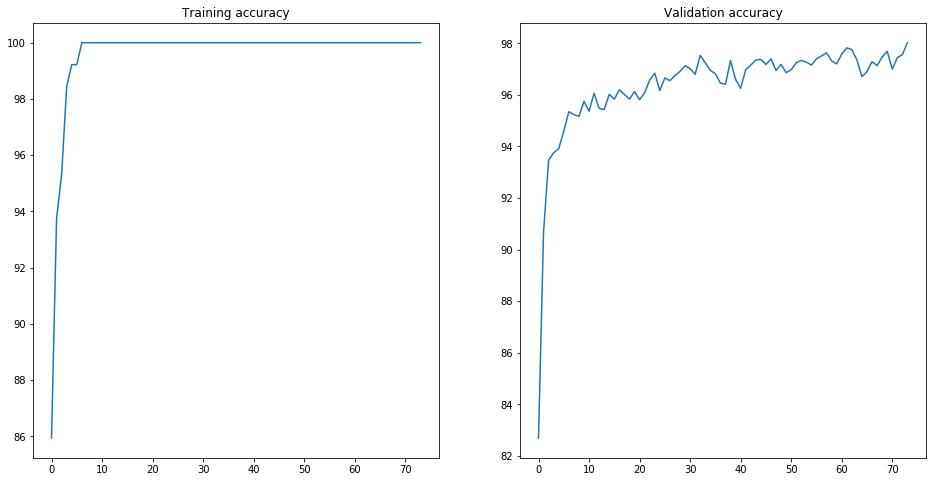

In [34]:
# Plot training and validation accuracy, and print the final results
iteration_vector = range(len(training_accuracy))

plt.subplot(121)
plt.plot(iteration_vector, np.array(training_accuracy));
plt.title('Training accuracy');

plt.subplot(122)
plt.plot(iteration_vector, np.array(validation_accuracy));
plt.title('Validation accuracy');

final_train_acc = training_accuracy[-1]
final_val_acc = validation_accuracy[-1]
   
print("Training accuracy: %.1f%%" % final_train_acc)
print('Validation accuracy: %.1f%%' % final_val_acc)      

In [35]:
print('Test accuracy: %.1f%%' % get_test_accuracy(X_test_preprocessed, y_test_preprocessed, test_batch_size))

Test accuracy: 96.3%


## Test a Model on New Images


### Acquiring New Images

I've found 10 different images of traffic signs on the internet using Google images search. I did not wanted to hardcode images into this file, so I put pairs "image_path"-"class" into a json file, which was used as my local database of images.

My data .json file:

{"array":[

{"path":"signs/ahead_only.jpg", "class":35},

{"path":"signs/bumpy_road.jpg","class":22},

{"path":"signs/general_caution.jpg","class":18},

{"path":"signs/keep_left.jpg","class":39},

{"path":"signs/no_entry.jpg","class":17},

{"path":"signs/priority_road.jpg","class":12},

{"path":"signs/speed_limit_30.jpg","class":1},

{"path":"signs/speed_limit_60.jpg","class":3},

{"path":"signs/stop.jpg","class":14},

{"path":"signs/turn_left_ahead.jpg","class":34}

]}

In [36]:
with open('data/my_signs.json', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())
    
img_size = (img_size_h, img_size_w)

signs_num = 10
X_my_test = np.zeros([signs_num, img_size_h, img_size_w, 3], dtype=np.float32)
y_my_test = np.zeros([signs_num], dtype=int)

for i, obj in enumerate(data["array"]):
    img_path = obj["path"]
    img_class = obj["class"]
    
    image = cv2.imread("data/"+img_path, 1)
    
    X_my_test[i, :, :, :] = image
    y_my_test[i] = img_class;
    
    print(img_class, img_path)

35 signs/ahead_only.jpg
22 signs/bumpy_road.jpg
18 signs/general_caution.jpg
39 signs/keep_left.jpg
17 signs/no_entry.jpg
12 signs/priority_road.jpg
1 signs/speed_limit_30.jpg
3 signs/speed_limit_60.jpg
14 signs/stop.jpg
34 signs/turn_left_ahead.jpg


In [37]:
# Preprocessing
X_my_test_preprocessed = preprocess_set(X_my_test)
y_my_test_preprocessed = one_hot_encoding(y_my_test, n_classes)

### Visualization of my images

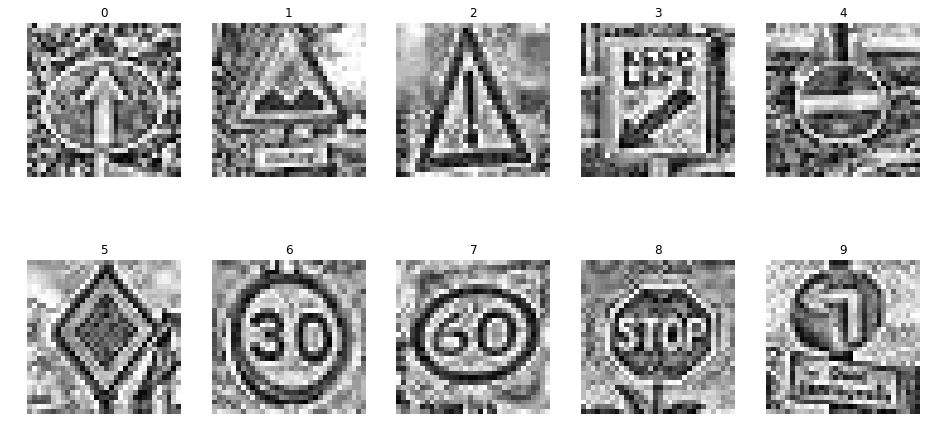

In [38]:
# Show examples of each class in dataset
for i in range(0, len(y_my_test)):
    plt.subplot(2, 5, i+1);
    plt.imshow(X_my_test_preprocessed[i].squeeze(), cmap='gray');
    plt.title(i);
    plt.axis('off');

### Exploration of random images

The images which may be difficult to classify are #1, #3, #7 and #9. Images #1 and #9 have text below them. Image #7 has unusual point of view and image #3 even contains a sign of different shape than examples in the German Traffic Signs dataset. 

### Performance on New Images and Softmax Probabilities

In [48]:
validation_acc_i = get_test_accuracy(X_my_test_preprocessed, y_my_test_preprocessed, 10)

print("My dataset accuracy: ", validation_acc_i, "%\n")

top_k_classes = 5
y_pred_own_top_k_prob = tf.nn.top_k(y_predicted, top_k_classes);

y_pred_own_prob, y_pred_own_idx = sess.run(y_pred_own_top_k_prob, feed_dict={x: X_my_test_preprocessed, dropout_keep_p: 1.0})

for i in range(X_my_test_preprocessed.shape[0]):
    for j in range(top_k_classes):
        if j == 0:
            print("Correct class of the random \"%s\" image is %d, prediction is correct: "
                  % (labels_text[y_my_test[i]], y_my_test[i]), 
                 y_pred_own_idx[i, j] == y_my_test[i])
            
        print("probability of \"%s\" is %f" % (labels_text[y_pred_own_idx[i, j]], 100.0 * y_pred_own_prob[i,j]))

My dataset accuracy:  70.0 %

Correct class of the random "Ahead only" image is 35, prediction is correct:  True
probability of "Ahead only" is 93.100351
probability of "Speed limit (70km/h)" is 5.900278
probability of "General caution" is 0.948107
probability of "Pedestrians" is 0.026920
probability of "Traffic signals" is 0.020229
Correct class of the random "Bumpy road" image is 22, prediction is correct:  False
probability of "Priority road" is 42.093447
probability of "No passing" is 29.786175
probability of "Speed limit (60km/h)" is 24.397101
probability of "Bicycles crossing" is 2.343925
probability of "Slippery road" is 1.335996
Correct class of the random "General caution" image is 18, prediction is correct:  True
probability of "General caution" is 99.999082
probability of "Road narrows on the right" is 0.000923
probability of "Pedestrians" is 0.000003
probability of "Traffic signals" is 0.000000
probability of "Bicycles crossing" is 0.000000
Correct class of the random "Keep

### Summary on the model certainty
 
My model showed performance of 70% on the random images which were found on the Internet. 
Images "Ahead only", "General caution", "No entry", "Priority road", "Speed limit (30km/h)", "Speed limit (60km/h)", "Stop" were classified correctly with very high probabiliy of 90% or above. 


The model could not classify "Keep left" image which was visualized above with index of 3. The unusual shape of traffic sign lead network to a conclusion that it is a "End of all speed and passing limits".

The network could not identify "Turn left ahead" and "Bumpy road" signs. As we can see, additional text in this images leads to uncertainty of classifier.